In [68]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.models import alexnet, AlexNet_Weights

# to read an image from a url
import imageio.v3 as iio

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt

# for importing the image files
import requests
from io import BytesIO

# for annotations
from typing import Sequence, Optional, Union, List, Dict, Any, Tuple

# Import AlexNet and Freeze all layers

In [69]:
alnet = alexnet(weights=AlexNet_Weights.DEFAULT)
# alexnet = torchvision.models.alexnet(pretrained=True)


for p in alnet.parameters():
  p.requires_grad = False

alnet.eval();

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alnet.to(device);

# Import Images

In [73]:
# Import Content and Style Images

content_url = 'https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg'

style_url = "https://commons.wikimedia.org/wiki/Special:FilePath/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg?width=1024"

header = {'User-Agent': 'Mozilla/5.0'}

resp = requests.get(content_url, headers=header, timeout=30)
resp.raise_for_status()

img4content = iio.imread(BytesIO(resp.content))

resp = requests.get(style_url, headers=header, timeout=30)
resp.raise_for_status()

img4style = iio.imread(BytesIO(resp.content))


In [74]:
# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(1675, 3000, 3)
(1675, 3000, 3)
(811, 1024, 3)


In [75]:
## These images are really large, which will make training take a long time.
## For VGG16 the mean and SD to normalize are [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225] respectively

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 323])


In [76]:
a = np.arange(2,3,4)
a

array([2])

In [77]:
import numpy as np
import torch
from typing import Sequence, Optional, Union

ArrayLike = Union[np.ndarray, torch.Tensor]

def denorm(
    x: ArrayLike,
    mean: Union[float, Sequence[float]],
    std:  Union[float, Sequence[float]],
    channel_axis: Optional[int] = None,
    inplace: bool = False,
    clip: Optional[tuple[float, float]] = None,
) -> ArrayLike:
    """
    Undo per-channel normalization: x = x*std + mean

    Works with NCHW, NHWC, CHW, HWC. Returns the same type as `x`.
    """
    is_torch = torch.is_tensor(x)

    # Prepare working copy
    a = x if inplace else (x if is_torch else x.copy())
    if is_torch and not inplace:
        a = x.clone()

    # Basic shape checks
    if a.ndim not in (2, 3, 4):
        raise ValueError(f"Expected 2D, 3D or 4D array/tensor, got shape {a.shape}")

    # Auto-detect channel axis if not provided
    if channel_axis is None:
        if a.ndim == 4:  # NCHW or NHWC
            # Heuristic: if axis 1 looks like channel count use 1 else use -1
            channel_axis = 1 if a.shape[1] in (1, 3, 4) and a.shape[-1] not in (1, 3, 4) else -1
        else:  # 3D: CHW or HWC
            channel_axis = 0 if a.shape[0] in (1, 3, 4) else -1

    # Channel count
    C = a.shape[channel_axis]

    # Convert mean/std to proper typed vectors
    if is_torch:
        dev, dtype = a.device, a.dtype
        mean_t = torch.as_tensor(mean, dtype=dtype, device=dev)
        std_t  = torch.as_tensor(std,  dtype=dtype, device=dev)
        if mean_t.ndim == 0: mean_t = mean_t.expand(C)
        if std_t.ndim  == 0: std_t  = std_t.expand(C)
        if mean_t.numel() != C or std_t.numel() != C:
            raise ValueError(f"mean/std length must equal channels ({C}), got {mean_t.numel()}/{std_t.numel()}")
        # Broadcast shape like (1, C, 1, 1) with channel at channel_axis
        shape = [1]*a.ndim
        shape[channel_axis] = C
        mean_t = mean_t.view(*shape)
        std_t  = std_t.view(*shape)
        # In-place if requested
        if inplace:
            a.mul_(std_t).add_(mean_t)
        else:
            a = a*std_t + mean_t
        if clip is not None:
            lo, hi = clip
            if inplace:
              a.clamp_(lo, hi)
            else:
              a = a.clamp(lo, hi)
        return a
    else:
        mean_np = np.asarray(mean, dtype=a.dtype)
        std_np  = np.asarray(std,  dtype=a.dtype)
        if mean_np.ndim == 0: mean_np = np.repeat(mean_np, C)
        if std_np.ndim  == 0: std_np  = np.repeat(std_np,  C)
        if mean_np.size != C or std_np.size != C:
            raise ValueError(f"mean/std length must equal channels ({C}), got {mean_np.size}/{std_np.size}")
        # Broadcast shape like (1, C, 1, 1) with channel at channel_axis
        shape = [1]*a.ndim
        shape[channel_axis] = C
        mean_np = mean_np.reshape(shape)
        std_np  = std_np.reshape(shape)
        a = a*std_np + mean_np if not inplace else np.multiply(a, std_np, out=a); np.add(a, mean_np, out=a)
        if clip is not None:
            lo, hi = clip
            np.clip(a, lo, hi, out=a)
        return a


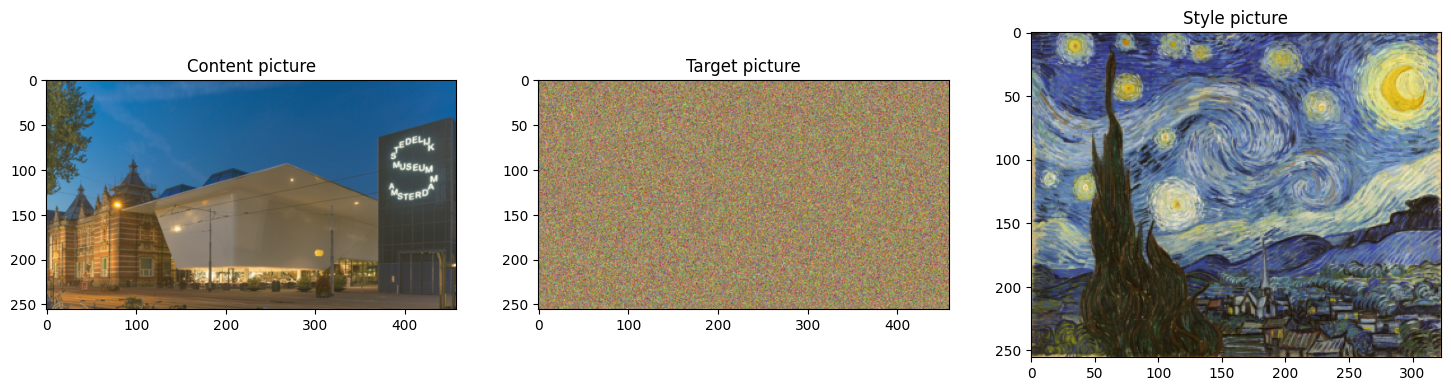

In [78]:
# Let's have a look at the "before" pics
mean = mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = denorm(pic, mean, std)
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = denorm(pic, mean, std)
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = denorm(pic, mean, std)
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show();

# Function to Extract Feature Map Activations

In [79]:
# A function that returns feature maps

def getFeatureMapActs(img,net):

  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):

    # process the image through this layer
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1

  return featuremaps,featurenames

In [80]:
# A function that returns the Gram matrix of the feature activation map
def gram_matrix(M):

  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

In [81]:
# inspect the output of the function
featmaps,featnames = getFeatureMapActs(img4content,alnet)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 63, 113])
Feature map "ConvLayer_1" is size torch.Size([1, 192, 31, 56])
Feature map "ConvLayer_2" is size torch.Size([1, 384, 15, 27])
Feature map "ConvLayer_3" is size torch.Size([1, 256, 15, 27])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 15, 27])


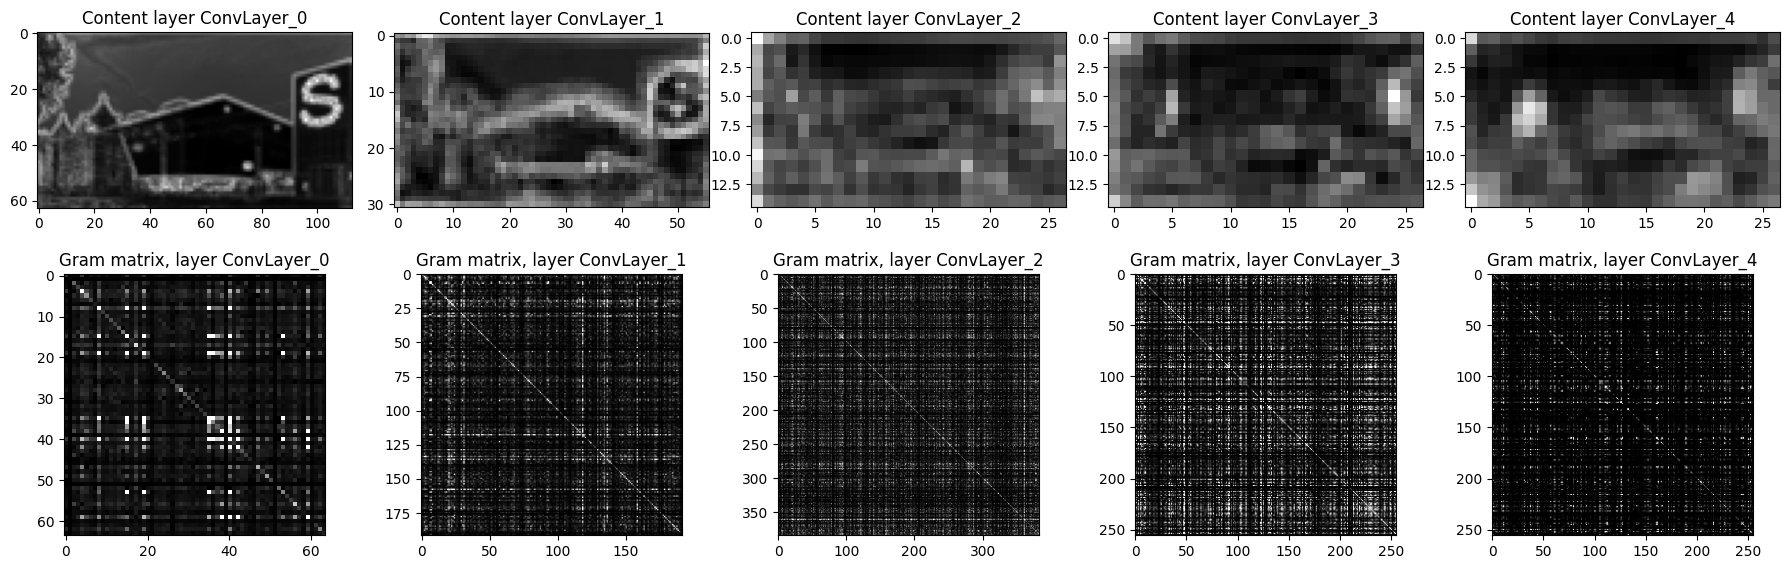

In [82]:
# View the content Image
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,alnet)

# Define mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and denormalize and clip
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  #

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  #

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

# Transfter from AlexNet to the new model

In [83]:
# Get the feature maps for Style Image
styleFeatureMaps, stypleDeatureNames = getFeatureMapActs(img4style, alnet)

In [84]:
# Select layers to be transferred
layers4content = [ 'ConvLayer_0']#,'ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [1,.5,.6,.8,1]

In [85]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e5

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,alnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss


  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


# Visualize the combined Image

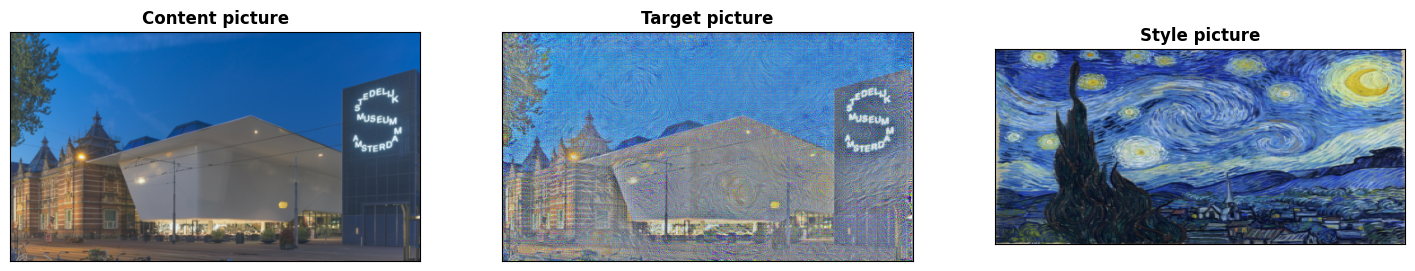

In [86]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
# pic = target.cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

In [ ]:
`